In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil
import time
import unittest

import numpy as np
import rospy
import matplotlib.pyplot as plt
import subprocess 
import shlex
from gazebo_msgs.msg import ModelState
from gazebo_msgs.srv import SetModelState
from geometry_msgs.msg import Pose
import xml.etree.ElementTree as ET
from scipy.interpolate import interp1d


from src.core.utils import get_filename_without_extension, get_to_root_dir
from src.core.data_types import TerminationType, SensorType
from src.sim.common.environment import EnvironmentConfig
from src.sim.ros.src.ros_environment import RosEnvironment
from src.sim.ros.test.common_utils import TopicConfig, TestPublisherSubscriber
from src.sim.ros.src.utils import transform

os.chdir("/home/klaas/code/imitation-learning-codebase")
os.getcwd()

'/home/klaas/code/imitation-learning-codebase'

In [2]:
def send_reference_and_set_goal(x: float = 0, y: float= 0, z: float= 0):
    args = shlex.split("rostopic pub /waypoint_indicator/current_waypoint std_msgs/Float32MultiArray '{data:[" + str(x) +", " + str(y) +", "+str(z)+"]}'")
    p = subprocess.Popen(args)
    time.sleep(1)
    p.terminate()
    margin = 0.5
    args = shlex.split("rosparam set /world/goal '{x: {min: " + str(x - margin) + ", max: " + str(x + margin) + "}, y: {min: "+ str(y - margin)+ ", max: "+ str(y + margin) + "}, z: {min: " + str(z - margin) + ", max: "+str(z + margin)+"}}'")
    subprocess.run(args)
    args = shlex.split("rosparam set /starting_height '"+str(z)+"'")
    subprocess.run(args)

In [3]:
target='line'

environment_config_dict = {
    "output_path": "draft_data_generation",
    "factory_key": "ROS",
    "max_number_of_steps": -1,
    "ros_config": {
        "observation": "camera",
        "info": ["position"],
        "max_update_wait_period_s": 10,
        "visible_xterm": True,
        "step_rate_fps": 100,
        "ros_launch_config": {
            "random_seed": 123, 
            "robot_name": "drone_sim_down_cam", # drone_sim, drone_sim_forward_cam
            "fsm_mode": "TakeOverRun",  # file with fsm params loaded from config/fsm
            "fsm": True,
            "altitude_control": True,
            "robot_display": False,
            "control_mapping": True,
            "waypoint_indicator": False,
            "control_mapping_config": "mathias_controller",
            "world_name": "gate_cone_line",
            "starting_height": 1.5, 
            "z_pos": 0.2,
            "yaw_or": 0.0,
            "gazebo": True,
        },
        "actor_configs": [{
            "name": "mathias_controller_with_KF",
            "file": f'{os.environ["CODEDIR"]}/src/sim/ros/config/actor/mathias_controller_with_KF.yml',
    }],
    }
}
config = EnvironmentConfig().create(
    config_dict=environment_config_dict
)
output_dir = config.output_path
environment = RosEnvironment(
    config=config
)

environment - INFO - initiated
process_wrappers - INFO - initiate
process_wrappers - INFO - run env -u SESSION_MANAGER xterm -iconic -l -lf "/home/klaas/code/imitation-learning-codebase/experimental_data/draft_data_generation/ros/21-05-11_17:29:01_xterm_output.log" -hold -e roslaunch  /home/klaas/code/imitation-learning-codebase/src/sim/ros/python3_ros_ws/src/imitation_learning_ros_package/launch/load_ros.launch output_path:=/home/klaas/code/imitation-learning-codebase/experimental_data/draft_data_generation store:='true' random_seed:=123 world_name:=gate_cone_line robot_name:=drone_sim_down_cam gazebo:='true' robot_display:='false' fsm:='true' fsm_mode:=TakeOverRun robot_mapping:='false' control_mapping:='true' control_mapping_config:=mathias_controller modified_state_publisher:='false' modified_state_publisher_mode:=CombinedGlobalPoses modified_state_frame_visualizer:='false' waypoint_indicator:='false' x_pos:=0.0 y_pos:=0.0 z_pos:=0.2 yaw_or:=0.0 starting_height:=1.5 distance_tracki

In [ ]:
environment.remove()

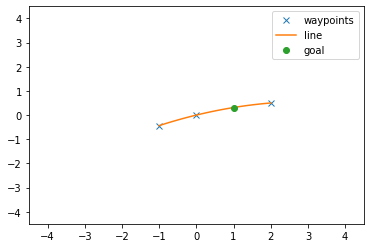

70 70


In [38]:
# create random line from x -4 till +4
number_of_points = 70
xmin = -1
xmax = 2
x = np.asarray([xmin, 0, xmax])
y = np.asarray([np.random.uniform(-xmin, xmin), 0, np.random.uniform(-xmax, xmax)])

interpolation = interp1d(x, y, kind='quadratic')
x_coords = np.linspace(xmin, xmax, num=number_of_points, endpoint=True)
y_coords = interpolation(x_coords)

# extract waypoint and goal
idx = (np.abs(x_coords - 1)).argmin()
x_g, y_g = x_coords[idx], y_coords[idx]

plt.figure()
plt.plot(x, y, 'x', x_coords, y_coords, '-', [x_g], [y_g], 'o')
plt.legend(['waypoints', 'line', 'goal'])
plt.xlim((-4.5, 4.5))
plt.ylim((-4.5, 4.5))
plt.show()
print(len(x_coords), len(y_coords))

In [39]:
def update_line_model():    
    # create random line from x -4 till +4
    number_of_points = 70
    xmin = -1
    xmax = 2
    x = np.asarray([xmin, 0, xmax])
    y = np.asarray([np.random.uniform(-xmin, xmin), 0, np.random.uniform(-xmax, xmax)])

    interpolation = interp1d(x, y, kind='quadratic')
    x_coords = np.linspace(xmin, xmax, num=number_of_points, endpoint=True)
    y_coords = interpolation(x_coords)

    # extract waypoint and goal
    goal_x_est = 1.75
    idx = (np.abs(x_coords - goal_x_est)).argmin()
    x_g, y_g = x_coords[idx], y_coords[idx]
    z_g = np.random.uniform(0.7, 1.7)
    send_reference_and_set_goal(x_g, y_g, z_g)

    plt.figure()
    plt.plot(x, y, 'x', x_coords, y_coords, '-', [x_g], [y_g], 'o')
    plt.legend(['waypoints', 'line', 'goal'])
    plt.xlim((-1.2, 2.2))
    plt.ylim((-xmax, xmax))
    plt.show()

    # create a world file with corresponding tubes
    r = 0.01
    l = 0.06

    # Load line_segment:
    model_dir = 'src/sim/ros/gazebo/models/line_segment'
    tree = ET.parse(os.path.join(os.environ['PWD'], model_dir, 'line.sdf'))
    root = tree.getroot()
    
    # remove any existing model
    for child in root:
        if child.get('name') == 'line':
            root.remove(child)

    # add model to world
    model = ET.SubElement(root, 'model', attrib={'name': 'line'})
    # Place small cylinders in one model
    for index, (x, y) in enumerate(zip(x_coords, y_coords)):
        static = ET.SubElement(model, 'static')
        static.text = '1'
        link=ET.SubElement(model, 'link', attrib={'name':f'link_{index}'})
        pose = ET.SubElement(link, 'pose', attrib={'frame':''})
        next_x = x_coords[(index + 1) % len(x_coords)]
        next_y = y_coords[(index + 1) % len(x_coords)]
        derivative = (next_y - y)/(next_x - x)
        slope = np.arctan(derivative)
        pose.text = f'{x} {y} {r} 0 1.57 {slope}'
        collision = ET.SubElement(link, 'collision', attrib={'name':'collision'})
        visual = ET.SubElement(link, 'visual', attrib={'name':'visual'})
        material = ET.SubElement(visual,'material')
        script = ET.SubElement(material,'script')
        name = ET.SubElement(script,'name')
        name.text='Gazebo/Black'
        uri = ET.SubElement(script,'uri')
        uri.text='file://media/materials/scripts/gazebo.material'
        for element in [collision,visual]: 
            geo = ET.SubElement(element, 'geometry')
            cylinder = ET.SubElement(geo, 'cylinder')
            radius = ET.SubElement(cylinder, 'radius')
            radius.text=str(r)
            length = ET.SubElement(cylinder, 'length')
            length.text=str(l)

    # Store model
    tree.write(os.path.join(os.environ['PWD'], model_dir, 'line.sdf'), encoding="us-ascii", xml_declaration=True, method="xml")
    
    return x_g, y_g, z_g
    

In [12]:
def spawn_line():
    reference_pos = update_line_model()
    args = shlex.split("rosrun gazebo_ros spawn_model -file " + os.environ["GAZEBO_MODEL_PATH"] + "/line_segment/line.sdf -sdf -model line -y 0 -x -0")
    subprocess.run(args)
    return reference_pos
    
def remove_line():
    args = shlex.split("rosservice call gazebo/delete_model '{model_name: line}'")
    subprocess.run(args)

In [46]:
relative_waypoint = transform(points=[np.asarray(reference_pos)],
                                  orientation=experience.info['position'][3:],
                                  translation=np.asarray(experience.info['position'][:3]), 
                                  invert=True)[0]
norm = np.sqrt(np.sum(relative_waypoint**2))
ref_distance = 0.5
scaled_waypoint = relative_waypoint * ref_distance / norm

0.5

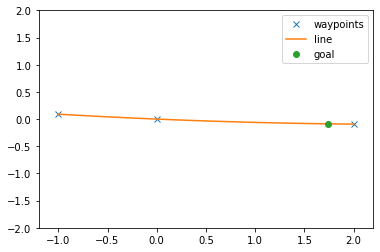

environment - INFO - resetting


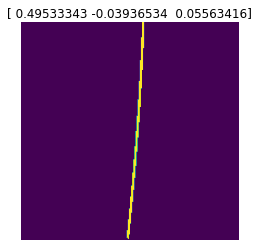

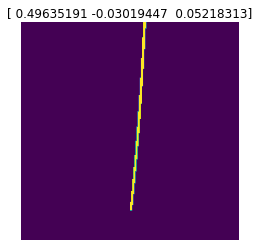

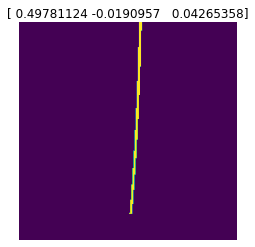

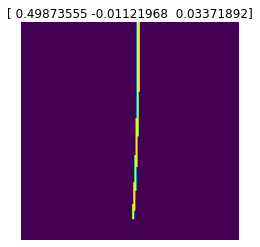

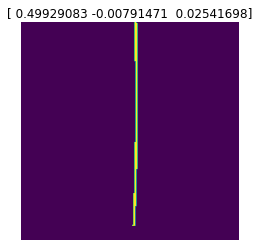

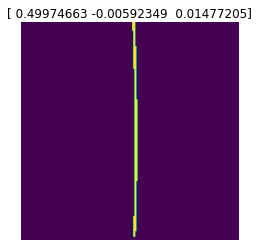

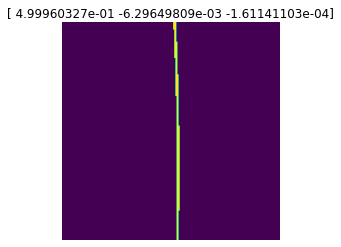

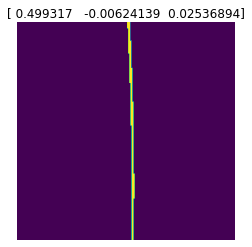

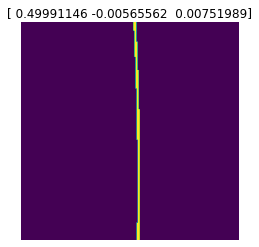

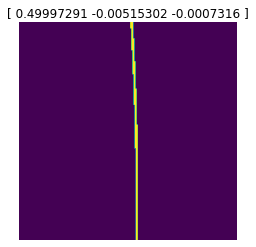

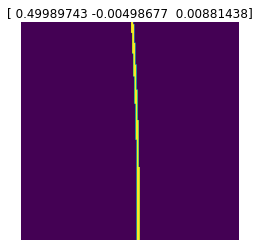

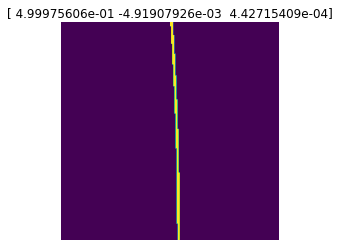

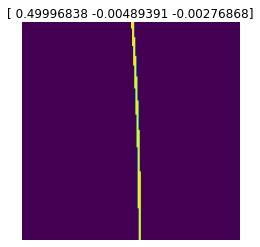

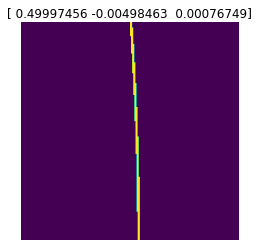

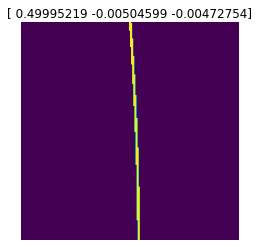

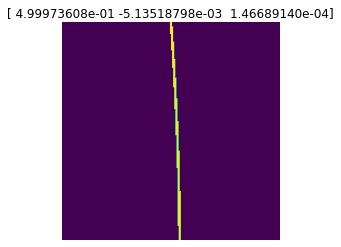

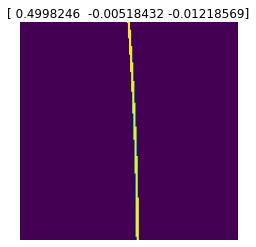

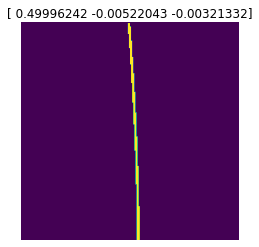

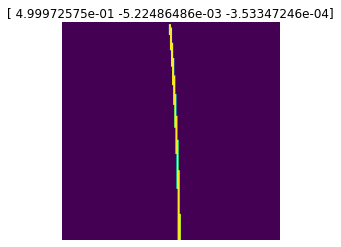

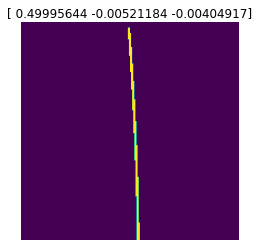

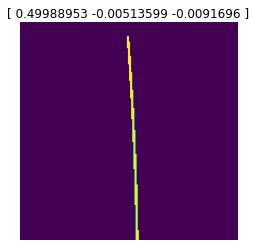

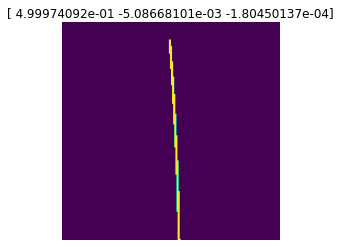

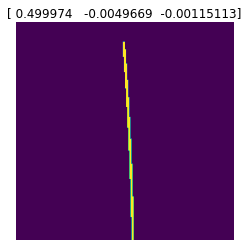

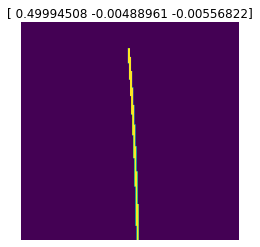

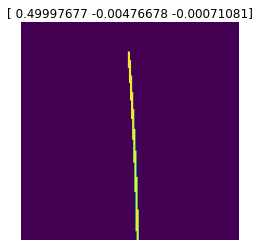

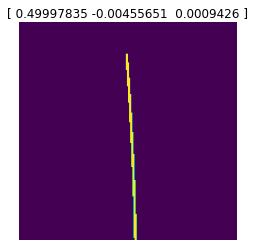

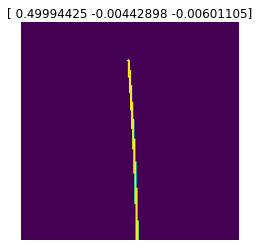

In [47]:
# Insert model
reference_pos = spawn_line()

# Perform run
experience, observation = environment.reset()
while experience.done == TerminationType.NotDone:
    experience, observation = environment.step()
    # relative pose should be at fixed xy-distance
    relative_waypoint = transform(points=[np.asarray(reference_pos)],
                                  orientation=experience.info['position'][3:],
                                  translation=np.asarray(experience.info['position'][:3]), 
                                  invert=True)[0]
    norm = np.sqrt(np.sum(relative_waypoint**2))
    ref_distance = 0.5
    scaled_waypoint = relative_waypoint * ref_distance / norm
    
    observation = experience.observation
    observation = np.mean(observation, axis=2)
    observation[observation==1] = 0
    observation[observation!=0] = 1
    plt.imshow(observation)
    plt.axis('off')
    plt.title(str(scaled_waypoint))
    plt.show()
    
# remove model
remove_line()


In [30]:
reference_pos

(1.0, 0.5700421092203075, 1.5640478381819034)

In [82]:
import yaml
# Create world config with waypoints
world_config_dir = 'src/sim/ros/config/world'
height = np.random.uniform(0.7, 1.7)
config = {
    'world_name': model_name,
    'max_duration': 60,
    'starting_height': height,
    'delay_evaluation': 1,
    'waypoints': [[x_g, y_g, height]],
    'waypoint_reached_distance': 0.2,
    'goal': {
        'x': {'min': x_g - 0.3,
              'max': x_g + 0.3},
        'y': {'min': y_g - 0.3,
              'max': y_g + 0.3},
        'z': {'min': height - 0.3,
              'max': height + 0.3},
    }
}

os.makedirs(os.path.join(os.environ['PWD'], world_config_dir, 'line_worlds'), exist_ok=True)
with open(os.path.join(os.environ['PWD'], world_config_dir, 'line_worlds', model_name + '.yml'), 'w') as f:
    yaml.dump(config, f)

In [ ]:
# test line data (mask, waypoint, flying behavior)
send_reference_and_set_goal(x, y, z)
# detect frame with too few in view to be usefull: threshold 1k for gate, 25 for cone
while experience.done == TerminationType.NotDone:
    experience, observation = environment.step()
    observation = experience.observation
    observation = np.mean(observation, axis=2)
    observation[observation==1] = 0
    observation[observation!=0] = 1
    plt.imshow(observation)
    plt.axis('off')
    plt.title(str(np.sum(observation)))
    plt.show()

(1.884628064494993, -1.2199392378625644, 1.3070788639770208)
environment - INFO - resetting


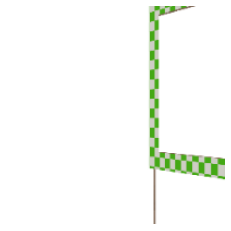

In [9]:
# Calibrate goal distance for gate
def set_random_gate_location():
    set_model_state_service = rospy.ServiceProxy('/gazebo/set_model_state', SetModelState)
    model_state = ModelState()
    model_state.pose = Pose()
    model_state.model_name = 'gate'
    model_state.pose.position.x = np.random.uniform(1, 4)
    model_state.pose.position.y = np.random.uniform(-model_state.pose.position.x, model_state.pose.position.x)
    yaw = np.sign(model_state.pose.position.y) * np.random.uniform(0, 30) * np.pi / 180
    model_state.pose.orientation.w = np.cos(yaw * 0.5)
    model_state.pose.orientation.z = np.sin(yaw * 0.5)
    set_model_state_service.wait_for_service()
    set_model_state_service(model_state)
    x = model_state.pose.position.x
    y = model_state.pose.position.y
    z = np.random.uniform(1.2, 1.7)
    send_reference_and_set_goal(x, y, z)
    return x, y, z


print(set_random_gate_location())

experience, observation = environment.reset()
plt.imshow(observation)
plt.axis('off')
plt.show()

environment - INFO - resetting


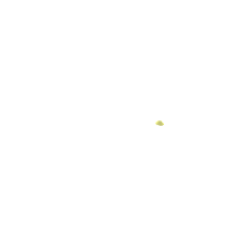

In [4]:
# Calibrate goal distance for cone
def set_random_cone_location():
    set_model_state_service = rospy.ServiceProxy('/gazebo/set_model_state', SetModelState)
    model_state = ModelState()
    model_state.pose = Pose()
    model_state.model_name = 'cone'
    model_state.pose.position.x = np.random.uniform(1.5, 4)
    model_state.pose.position.y = np.random.uniform(-model_state.pose.position.x/2, model_state.pose.position.x/2)
    set_model_state_service.wait_for_service()
    set_model_state_service(model_state)
    z = np.random.uniform(0.7, 1.7)
    x = model_state.pose.position.x
    y = model_state.pose.position.y
    send_reference_and_set_goal(x, y, z)
    return x, y, z


reference_pos = set_random_cone_location()
experience, observation = environment.reset()
plt.imshow(observation)
plt.axis('off')
plt.show()

In [121]:
def draw_line_segment(n: float=0, x: float = 0, y: float=0, z:float=0):
    args = shlex.split("rosrun gazebo_ros spawn_model -file "+str(os.environ["GAZEBO_MODEL_PATH"])+"/line_segment/line.sdf -sdf -model line"+str(n)+" -z "+str(z)+" -y "+str(y)+" -x "+str(x))
    subprocess.run(args)

draw_line_segment(0, 0, 0, 0)

In [ ]:
# get relative waypoint
while experience.done == TerminationType.NotDone:
    experience, observation = environment.step()
    relative_waypoint = transform(points=[np.asarray(reference_pos)],
                                  orientation=experience.info['position'][3:],
                                  translation=np.asarray(experience.info['position'][:3]), 
                                  invert=True)[0]
    plt.imshow(observation)
    plt.axis('off')
    plt.title(str(relative_waypoint))
    plt.show()


[]

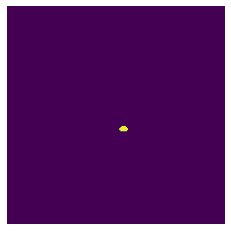

In [10]:
# get mask
observation = experience.observation
plt.imshow(observation)
plt.axis('off')
plt.plot()

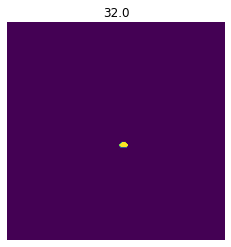

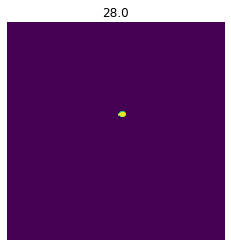

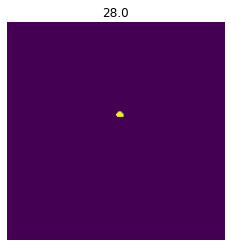

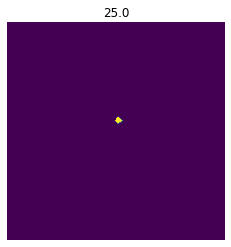

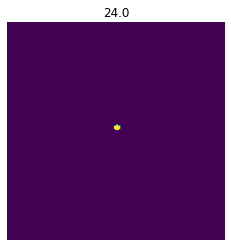

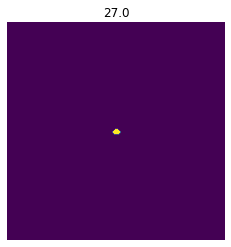

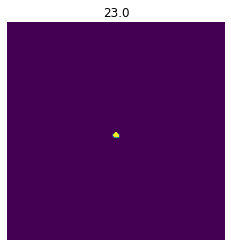

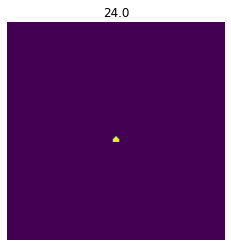

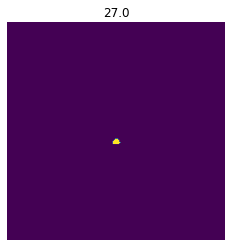

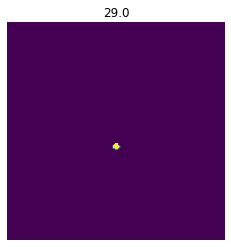

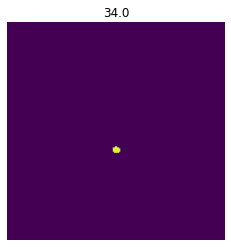

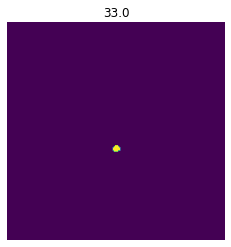

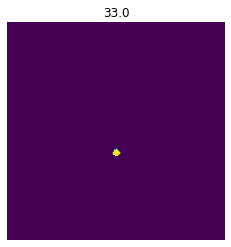

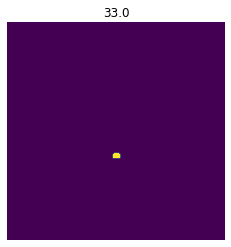

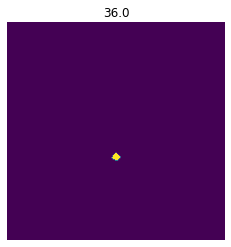

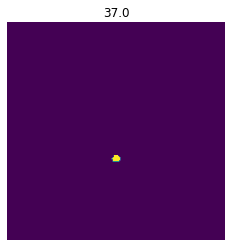

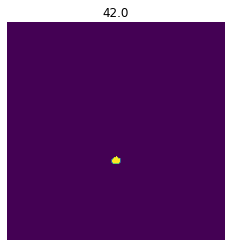

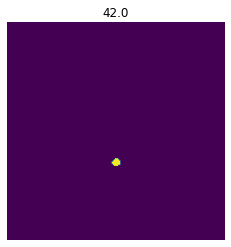

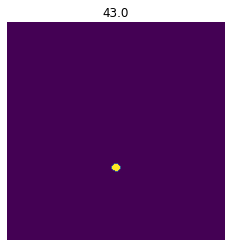

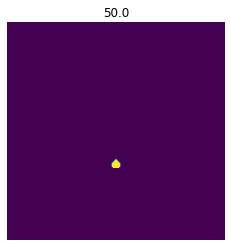

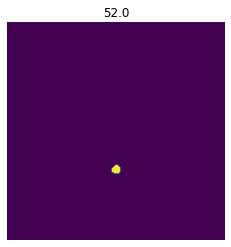

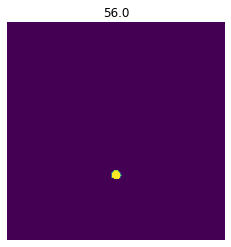

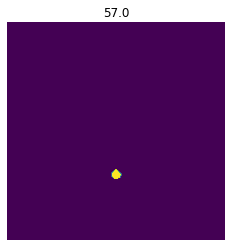

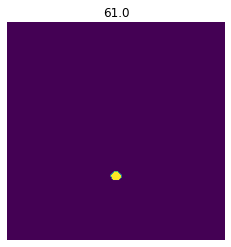

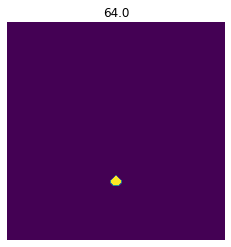

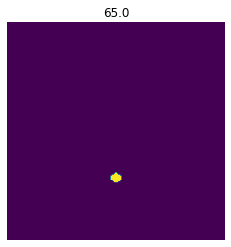

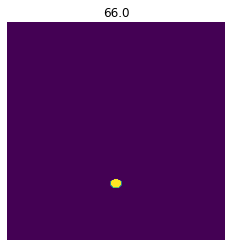

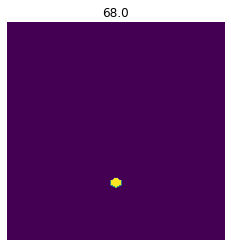

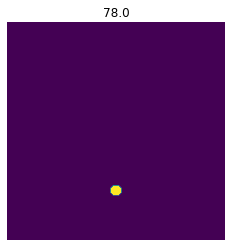

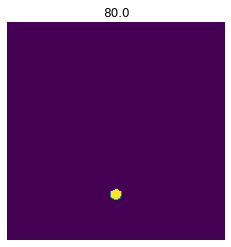

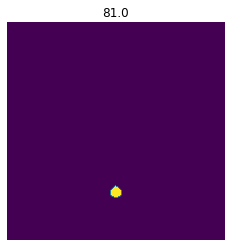

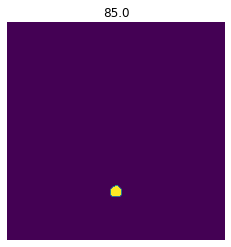

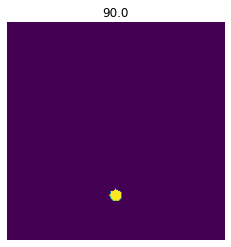

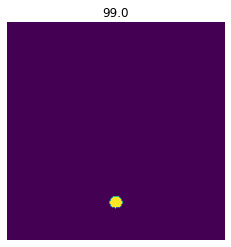

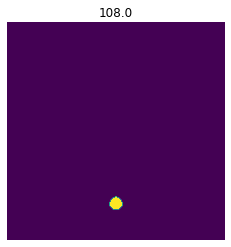

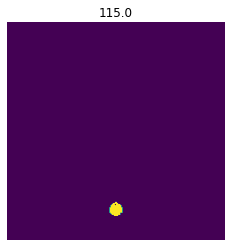

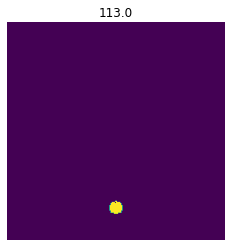

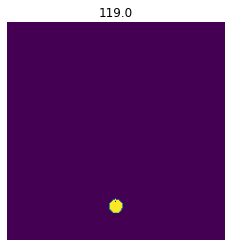

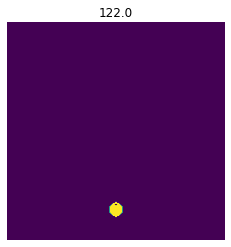

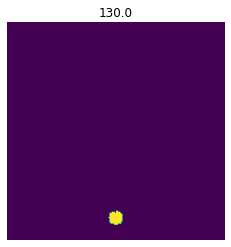

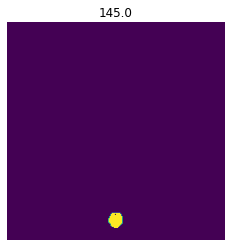

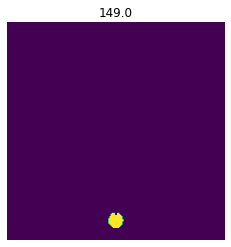

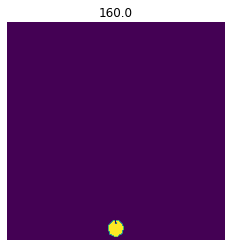

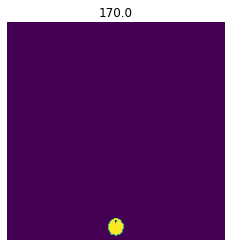

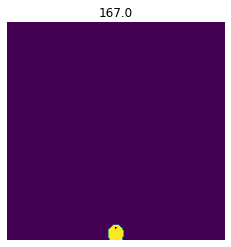

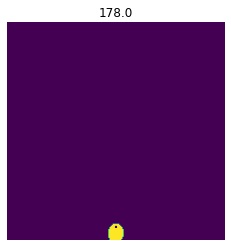

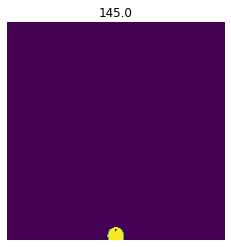

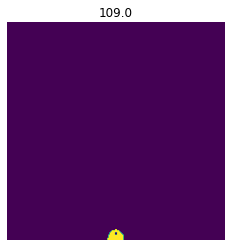

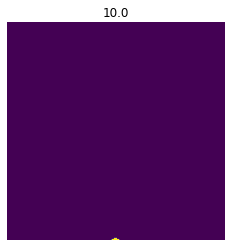

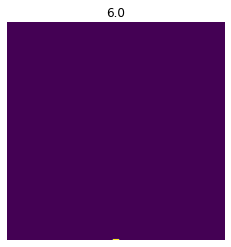

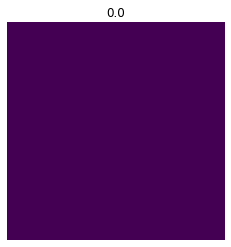

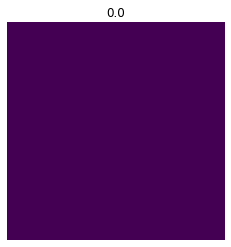

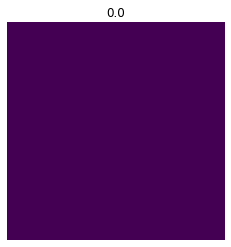

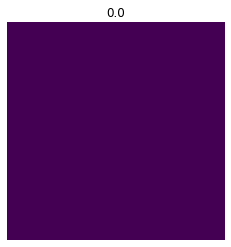

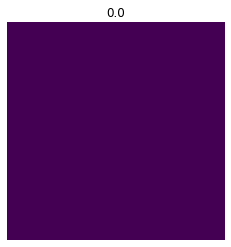

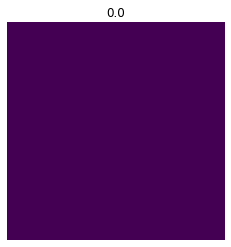

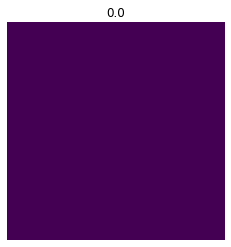

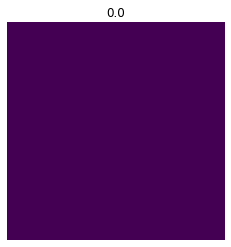

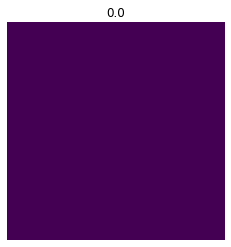

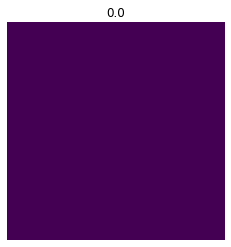

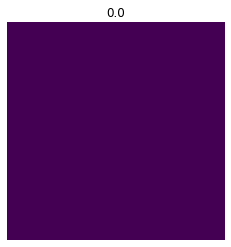

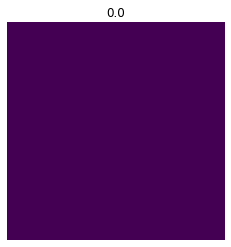

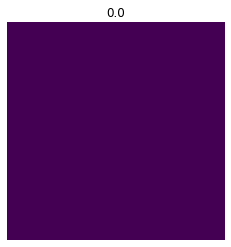

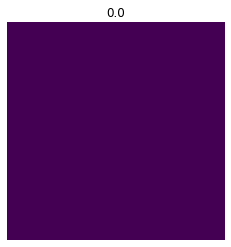

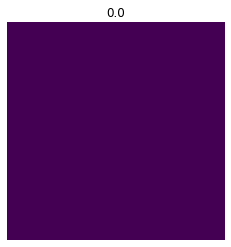

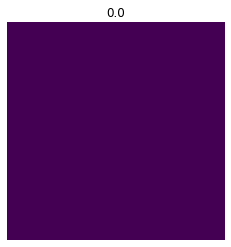

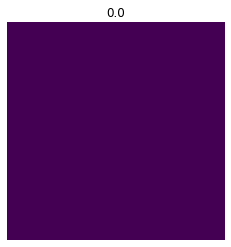

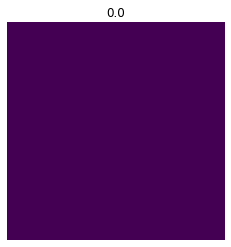

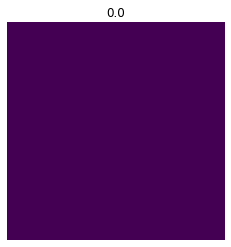

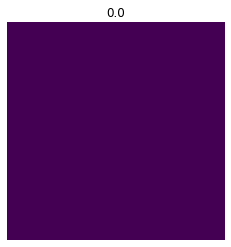

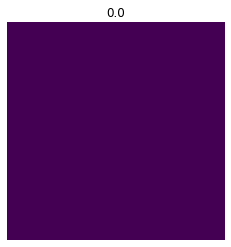

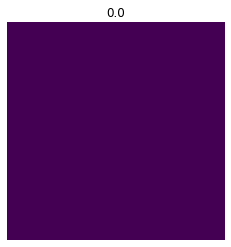

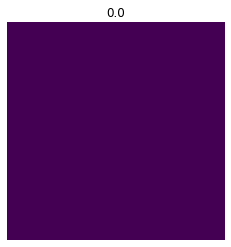

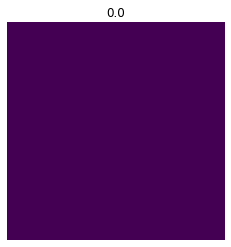

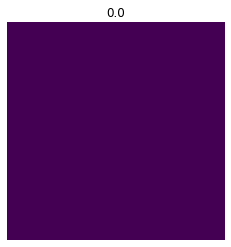

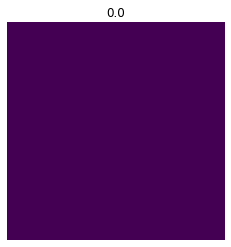

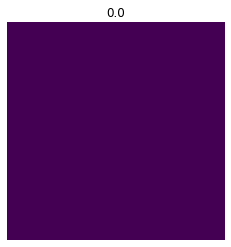

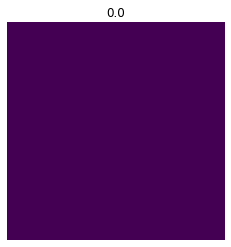

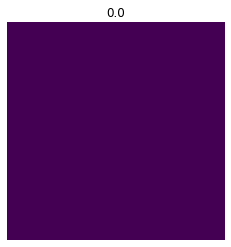

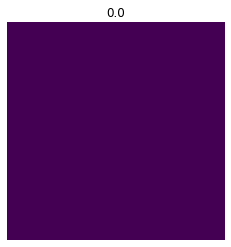

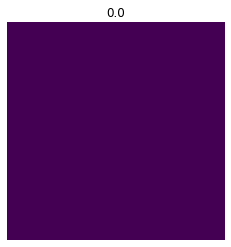

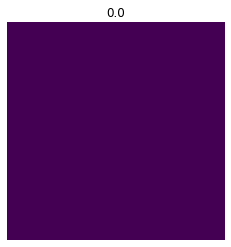

In [11]:
# detect frame with too few in view to be usefull: threshold 1k for gate, 25 for cone
while experience.done == TerminationType.NotDone:
    experience, observation = environment.step()
    observation = experience.observation
    observation = np.mean(observation, axis=2)
    observation[observation==1] = 0
    observation[observation!=0] = 1
    plt.imshow(observation)
    plt.axis('off')
    plt.title(str(np.sum(observation)))
    plt.show()

In [5]:
from copy import deepcopy

def save(reference_pos,
         experience, 
         json_data, 
         hdf5_data):
    # calculate mask
    mask = deepcopy(experience.observation)
    mask = np.mean(mask, axis=2)
    mask[mask==1] = 0
    mask[mask!=0] = 1
    
    # don't save is item not in view
    if np.sum(mask) < (1000 if target == 'gate' else 20):
        return
        
    # store mask    
    hdf5_data["mask"].append(mask)
    
    # store previous observation
    hdf5_data["observation"].append(deepcopy(experience.observation))
    
    # store velocity
    action = experience.action.value
    json_data["velocities"].append([action[0], action[1], action[2], action[5]])
    
    # store relative tarbet location
    relative_reference_position = transform(points=[np.asarray(reference_pos)],
                                            orientation=experience.info['position'][3:],
                                            translation=np.asarray(experience.info['position'][:3]), 
                                            invert=True)[0]
    json_data["relative_target_location"].append(list(relative_reference_position))
    
    # store global target location
    json_data["global_target_location"].append(list(reference_pos))

    # store global drone location
    json_data["global_drone_pose"].append(list(experience.info['position']))


In [12]:
# create output json and hdf5 file
json_data = {
    "velocities": [], 
    "global_target_location": [], 
    "relative_target_location": [],
    "global_drone_pose": []}
hdf5_data = {"mask": [], 
             "observation": []}

In [13]:
# collect info in corresponding objects
reference_pos = set_random_cone_location()
experience, observation = environment.reset()
while experience.done == TerminationType.NotDone:
    experience, observation = environment.step()
    save(reference_pos, experience, json_data, hdf5_data)

environment - INFO - resetting


In [14]:
# dump data if run is successfully
import json
import h5py

def dump(json_data, hdf5_data, output_dir):
    output_json_path = os.path.join(output_dir, 'data') + '.json'
    output_hdf5_path = os.path.join(output_dir, 'data') + '.hdf5'
    if os.path.isfile(output_json_path):
        with open(output_json_path, "r+") as f:
            stored_data = json.load(f)
    else:
        stored_data = {"episodes": []}
    episode_id = len(stored_data["episodes"])
    stored_data["episodes"].append(json_data)
    with open(output_json_path, "w") as f:
        json.dump(stored_data, f)

    hdf5_file = h5py.File(output_hdf5_path, "a")
    episode_group = hdf5_file.create_group(str(episode_id))
    for sensor_name in hdf5_data.keys():
        episode_group.create_dataset(
            sensor_name, data=np.stack(hdf5_data[sensor_name])
        )
    hdf5_file.close()


if experience.done == TerminationType.Success:
    dump(json_data, hdf5_data, output_dir)
    

77.9022273338099 100.74773182477117


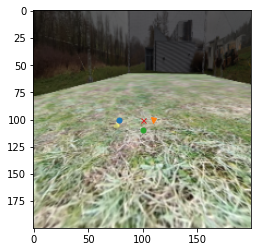

In [103]:
# draft cone localization algorithm

# load image 
relative_pose = np.array([ 3.55525111,  0.71421028, -0.02416704])
observation = np.load('observation.npy')

f = 110
pixel_horizontal = -f * relative_pose[1] / relative_pose[0] + 100
pixel_vertical = -f * relative_pose[2] / relative_pose[0] + 100

print(pixel_horizontal, pixel_vertical)
plt.imshow(observation)
plt.plot(pixel_horizontal, pixel_vertical, 'o', markersize=5)
plt.plot(observation.shape[0]//2 + 10, observation.shape[1] // 2, 'v', markersize=5)
plt.plot(observation.shape[0]//2, observation.shape[1] // 2 + 10, 'o', markersize=5)
plt.plot(observation.shape[0]//2, observation.shape[1] // 2, 'x', markersize=5)
plt.show()
# More difficult than expected due to
# - varying camera orientation is not taken into account with reference pose relative to drone instead of camera frame
# - gate and line are not a point so will not be easily places in a region

In [113]:
import json
# validate intrinsics 
with open('/home/klaas/code/imitation-learning-codebase/experimental_data/cone_gate_line_datasets/gate/data.json', 'r') as f:
    data = json.load(f)
#hdf5_file = h5py.File('experimental_data/gate_cone_line/cone/data.json', "r")
#hdf5_file.keys()
np.mean([len(d['velocities']) for k, d in data.items()])

47.93